<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Human/GrondTruth Versus AI  Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine whether AI answers match Human Groundtruth answers. In many Q&A systems its important to test the AI answer results as compared to Human answers prior to deployment. These help assess how often the answers are correctly generated by the AI system. 

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted Evals for AI vs Human answers 
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [2]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.experimental.evals import (
    HUMAN_VS_AI_PROMPT_TEMPLATE,
    HUMAN_VS_AI_PROMPT_RAILS_MAP,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"

In [3]:
csv_file_path = 'https://storage.googleapis.com/arize-assets/phoenix/evals/human_vs_ai/human_vs_ai_classifications.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path).dropna(subset=['correct_answer']).reset_index(drop=True)
df.head()

,Unnamed: 0,question,Out-of-doc,Topic,notes,correct_answer,ai_generated_answer,human_ai_eval,human_ai_explanation,ai_answer,true_value,Who Answered?,incorrect_answer,ai_questions
0,NaN,Does Arize support total token usage tracking?,NaN,NaN,NaN,Arize supports tracking token usage both prompt and completion usage. Additionally costs can be calculated based on usage.,NaN,NaN,NaN,Arize supports tracking prompt and completion token usage.,True,NaN,NaN,NaN
1,NaN,What is LLM Observability?,NaN,NaN,NaN,"Large Language Model (LLMs) similar to traditional machine learning need production Observability for deployed sytems. Arguablly the LLMs have a wider range of possible actions. tend to be less predictable and have a wide range of potential output problems inclding hallcinations. Observability and LLM Evaluation plays a similar role in LLMs to surface issues, monitor for problems and iterate / improve on data. We need to understand when issues occur, where and why they happen and have the ability to quickly resolve and root cause issues.",NaN,NaN,NaN,LLM Observability is the ability to watch LLMs as they are put into produciton.,False,NaN,NaN,NaN
2,NaN,What Evals are supported for LLMs or generative models?,NaN,NaN,NaN,"Arize supports a suite of Evals available from the Phoenix Evals library, they include both pre-tested Evals and the ability to configure cusotm Evals. Some of the pre-tested LLM Evals are listed below:\nRetrieval Relevance \nQuestion and Answer \nToxicity\nHuman Groundtruth vs AI \nCitation Reference Link Relevancy \nCode Readability \nHallucination Detection \nSummarizaiton",Arize supports LLM Evals.,NaN,NaN,Arize supports LLM Evals.,False,NaN,NaN,NaN
3,NaN,Does Arize support tracing for LangChain and LlamaIndex LLM spans?,NaN,NaN,NaN,"Arize supports tracking LLM span data from LlamaIndex and LangChain using the Arize OpenInference callback handler. We have one-click tracking support for both of those frameworks that capture trace data for embedding spans, retrieval spans, LLM spans, and chain spans.","Arize supports tracking LLM span data from LlamaIndex and LangChain using the Arize OpenInference callback handler. We have one-click tracking support for both of those frameworks that capture trace data for embedding spans, retrieval spans, LLM spans, and chain spans.",NaN,NaN,"Arize supports span tracking with LlamaIndex and LangChain, one-click tracing. The LLM span tracing includes tracking of the following span types:\n- retrieval spans\n- LLM Spans\n- chain spans\n-embedding spans",True,NaN,NaN,NaN
4,NaN,How do I use the SDK to upload a ranking model?,NaN,NaN,NaN,"A ranking model is integrated into the SDK where each row is an item in the ranked list. The three fields that need to be integrated are rank, relevance_score and prediction_group_id. The ""rank"" determines the rank number of this item in the list. The relevance_score represents the estimated probability of clicking on that item. The prediction_group_id groups the ranked items into a list, representing the set for a speciifc query.","To upload a ranking model using the SDK, you would typically follow these steps:\n\n1. Install the SDK in your Python environment if you haven't already done so.\n2. Import the SDK into your Python script where you plan to upload the model data.\n3. Configure the SDK with your Arize API key and space key to authenticate your requests.\n4. Define your model schema, including fields like `rank`, `prediction_score`, and `prediction_group_id`.\n5. Use the SDK functions to log model predictions, actuals, and any additional metadata related to your ranking model.\n6. Once your data is prepared, call the appropriate function provided by the SDK to send your ranking model data to the Arize platform.\n\nThe exact function names and parameters may vary based on the SDK version and the specifics of the ranking model you are working with. You should refer to the SDK documentation for detailed instructions on logging model schemas and s

##  Vizualization of Prompts/Templates Evals in Phoenix (Optional Section)

Visualization of Evals is not required but can be helpful to see the actual calls to the LLM. 
The link below starts the Phoenix UI/server and is a link to Phoenix running locally

In [4]:
from phoenix.trace.tracer import Tracer
from phoenix.trace.openai.instrumentor import OpenAIInstrumentor
from phoenix.trace.exporter import HttpExporter
from phoenix.trace.openai import OpenAIInstrumentor
from phoenix.trace.tracer import Tracer

In [5]:
import phoenix as px
session = px.launch_app()
tracer = Tracer(exporter=HttpExporter())
OpenAIInstrumentor(tracer).instrument()

🌍 To view the Phoenix app in your browser, visit http://127.0.0.1:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


![Image Description](https://storage.googleapis.com/arize-assets/phoenix/assets/images/RAG_trace_details.png)


## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(HUMAN_VS_AI_PROMPT_TEMPLATE)


You are comparing a human ground truth answer from an expert to an answer from an AI model. 
Your goal is to determine if the AI answer correctly matches, in substance, the human answer.
    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Human Ground Truth Answer]: {correct_answer}
    ************
    [AI Answer]: {ai_generated_answer}
    ************
    [END DATA]
Compare the AI answer to the human ground truth answer, if the AI correctly answers the question,
then the AI answer is "correct". If the AI answer is longer but contains the main idea of the 
Human answer please answer "correct". If the AI answer divergences or does not contain the main
idea of the human answer, please answer "incorrect".



The template variables are:

- **question:** the question asked by a user
- **correct_answer:** human labeled correct answer 
- **ai_answer:** AI generated answer

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## LLM Evals:Human Groundtruth vs AI GPT-4
Run Human vs AI Eval against a subset of the data.
Instantiate the LLM and set parameters.

In [8]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [9]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Classifications with explanations

When evaluating a dataset for relevance, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [10]:
import nest_asyncio
nest_asyncio.apply() 
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(HUMAN_VS_AI_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=HUMAN_VS_AI_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    verbose=True,
    provide_explanation=True,
    concurrency=50
)

Using prompt:


You are comparing a human ground truth answer from an expert to an answer from an AI model. 
Your goal is to determine if the AI answer correctly matches, in substance, the human answer.
    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Human Ground Truth Answer]: {correct_answer}
    ************
    [AI Answer]: {ai_generated_answer}
    ************
    [END DATA]

Compare the AI answer to the human ground truth answer, 
You are going to respond with both a LABEL (a single word evaluation) and an explanation 
of your reasoning. If the AI correctly answers the question as compared to the human answer,
then the AI answer LABEL is "correct". If the AI answer is longer but contains the main idea of the 
Human answer please answer LABEL "correct". If the AI answer divergences or does not contain the main
idea of the human answer, please answer LABEL "incorrect". Then write out in a step by step manner an
EXPLANATION to show how you evaluat

llm_classify |          | 1/119 (0.8%) | ⏳ 00:03<06:33 |  3.33s/it

- Snapped 'incorrect' to rail: incorrect


llm_classify |▏         | 2/119 (1.7%) | ⏳ 00:04<03:35 |  1.84s/it 

- Snapped 'correct' to rail: correct


llm_classify |▍         | 5/119 (4.2%) | ⏳ 00:05<01:13 |  1.55it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |▌         | 6/119 (5.0%) | ⏳ 00:05<01:09 |  1.62it/s 

- Snapped 'correct' to rail: correct


llm_classify |▌         | 7/119 (5.9%) | ⏳ 00:06<01:01 |  1.81it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |▊         | 9/119 (7.6%) | ⏳ 00:06<00:42 |  2.56it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |▊         | 10/119 (8.4%) | ⏳ 00:07<00:57 |  1.88it/s

- Snapped 'incorrect' to rail: incorrect


llm_classify |▉         | 11/119 (9.2%) | ⏳ 00:07<00:49 |  2.19it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |█         | 13/119 (10.9%) | ⏳ 00:08<00:42 |  2.49it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |█▎        | 16/119 (13.4%) | ⏳ 00:08<00:22 |  4.68it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |█▍        | 17/119 (14.3%) | ⏳ 00:08<00:27 |  3.71it/s 

- Snapped 'correct' to rail: correct


llm_classify |█▌        | 18/119 (15.1%) | ⏳ 00:09<00:28 |  3.53it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |█▊        | 21/119 (17.6%) | ⏳ 00:09<00:19 |  5.01it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |██        | 25/119 (21.0%) | ⏳ 00:09<00:12 |  7.50it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |██        | 25/119 (21.0%) | ⏳ 00:10<00:12 |  7.50it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |██▎       | 27/119 (22.7%) | ⏳ 00:10<00:13 |  6.91it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect


llm_classify |██▍       | 29/119 (24.4%) | ⏳ 00:10<00:14 |  6.29it/s 

- Snapped 'correct' to rail: correct


llm_classify |██▌       | 31/119 (26.1%) | ⏳ 00:11<00:16 |  5.39it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |██▋       | 32/119 (26.9%) | ⏳ 00:11<00:17 |  4.92it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |██▊       | 33/119 (27.7%) | ⏳ 00:11<00:18 |  4.69it/s 

- Snapped 'correct' to rail: correct


llm_classify |██▊       | 34/119 (28.6%) | ⏳ 00:12<00:26 |  3.21it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |███       | 36/119 (30.3%) | ⏳ 00:12<00:19 |  4.24it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect


llm_classify |███▏      | 38/119 (31.9%) | ⏳ 00:13<00:19 |  4.25it/s 

- Snapped 'correct' to rail: correct


llm_classify |███▎      | 40/119 (33.6%) | ⏳ 00:13<00:18 |  4.18it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |███▍      | 41/119 (34.5%) | ⏳ 00:13<00:18 |  4.18it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect


llm_classify |███▌      | 43/119 (36.1%) | ⏳ 00:13<00:13 |  5.67it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |████      | 48/119 (40.3%) | ⏳ 00:14<00:09 |  7.89it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |████▏     | 50/119 (42.0%) | ⏳ 00:14<00:08 |  7.89it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |████▎     | 52/119 (43.7%) | ⏳ 00:15<00:13 |  5.09it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |████▌     | 54/119 (45.4%) | ⏳ 00:15<00:13 |  4.93it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |████▌     | 55/119 (46.2%) | ⏳ 00:16<00:13 |  4.81it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |████▊     | 57/119 (47.9%) | ⏳ 00:16<00:10 |  5.68it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |████▉     | 59/119 (49.6%) | ⏳ 00:16<00:11 |  5.06it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |█████▏    | 62/119 (52.1%) | ⏳ 00:17<00:10 |  5.39it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |█████▏    | 62/119 (52.1%) | ⏳ 00:17<00:10 |  5.39it/s 

- Snapped 'correct' to rail: correct


llm_classify |█████▍    | 64/119 (53.8%) | ⏳ 00:17<00:10 |  5.09it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |█████▌    | 66/119 (55.5%) | ⏳ 00:18<00:08 |  5.99it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |█████▋    | 68/119 (57.1%) | ⏳ 00:18<00:07 |  6.83it/s 

- Snapped 'correct' to rail: correct


llm_classify |█████▉    | 71/119 (59.7%) | ⏳ 00:18<00:07 |  6.73it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect


llm_classify |██████▎   | 75/119 (63.0%) | ⏳ 00:18<00:04 |  9.42it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |██████▍   | 77/119 (64.7%) | ⏳ 00:19<00:03 | 11.21it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |██████▍   | 77/119 (64.7%) | ⏳ 00:19<00:03 | 11.21it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |██████▋   | 80/119 (67.2%) | ⏳ 00:20<00:07 |  5.49it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |██████▋   | 80/119 (67.2%) | ⏳ 00:20<00:07 |  5.49it/s 

- Snapped 'correct' to rail: correct


llm_classify |███████   | 84/119 (70.6%) | ⏳ 00:20<00:04 |  7.12it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect
- Snapped 'incorrect' to rail: incorrect


llm_classify |███████▎  | 87/119 (73.1%) | ⏳ 00:20<00:04 |  6.94it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |███████▍  | 89/119 (74.8%) | ⏳ 00:20<00:03 |  9.54it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |███████▋  | 91/119 (76.5%) | ⏳ 00:21<00:03 |  8.39it/s 

- Snapped 'correct' to rail: correct


llm_classify |███████▊  | 93/119 (78.2%) | ⏳ 00:21<00:03 |  6.61it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |███████▉  | 95/119 (79.8%) | ⏳ 00:22<00:04 |  5.19it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |████████▏ | 98/119 (82.4%) | ⏳ 00:22<00:03 |  6.80it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |████████▎ | 99/119 (83.2%) | ⏳ 00:22<00:02 |  6.80it/s 

- Snapped 'correct' to rail: correct
- Snapped 'incorrect' to rail: incorrect


llm_classify |████████▍ | 101/119 (84.9%) | ⏳ 00:22<00:02 |  7.78it/s

- Snapped 'correct' to rail: correct


llm_classify |████████▌ | 102/119 (85.7%) | ⏳ 00:23<00:02 |  6.84it/s 

- Snapped 'correct' to rail: correct


llm_classify |████████▋ | 103/119 (86.6%) | ⏳ 00:23<00:04 |  3.53it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |████████▉ | 106/119 (89.1%) | ⏳ 00:24<00:02 |  4.80it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |█████████ | 108/119 (90.8%) | ⏳ 00:24<00:02 |  4.24it/s 

- Snapped 'incorrect' to rail: incorrect
- Snapped 'correct' to rail: correct


llm_classify |█████████▏| 109/119 (91.6%) | ⏳ 00:24<00:02 |  4.85it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |█████████▍| 112/119 (94.1%) | ⏳ 00:25<00:01 |  5.92it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |█████████▍| 113/119 (95.0%) | ⏳ 00:25<00:00 |  6.26it/s 

- Snapped 'correct' to rail: correct
- Snapped 'correct' to rail: correct


llm_classify |█████████▋| 115/119 (96.6%) | ⏳ 00:25<00:00 |  6.50it/s 

- Snapped 'correct' to rail: correct


llm_classify |█████████▋| 116/119 (97.5%) | ⏳ 00:26<00:00 |  4.29it/s 

- Snapped 'correct' to rail: correct


llm_classify |█████████▊| 117/119 (98.3%) | ⏳ 00:28<00:01 |  1.28it/s 

- Snapped 'incorrect' to rail: incorrect


llm_classify |█████████▉| 118/119 (99.2%) | ⏳ 00:29<00:00 |  1.54it/s 

- Snapped 'correct' to rail: correct


llm_classify |██████████| 119/119 (100.0%) | ⏳ 00:31<00:00 |  1.07s/it

- Snapped 'incorrect' to rail: incorrect


llm_classify |██████████| 119/119 (100.0%) | ⏳ 00:32<00:00 |  3.68it/s


In [11]:
# Let's view the data
merged_df = pd.merge(
    df, relevance_classifications, left_index=True, right_index=True
)
merged_df[["question", "correct_answer","ai_generated_answer" , "label", "explanation"]].head()

,question,correct_answer,ai_generated_answer,label,explanation
0,Does Arize support total token usage tracking?,Arize supports tracking token usage both prompt and completion usage. Additionally costs can be calculated based on usage.,NaN,incorrect,"The AI answer is 'nan', which is not a valid response to the question. It does not provide any information about whether Arize supports total token usage tracking or not. Therefore, it does not match the substance of the human ground truth answer, which clearly states that Arize does support tracking token usage."
1,What is LLM Observability?,"Large Language Model (LLMs) similar to traditional machine learning need production Observability for deployed sytems. Arguablly the LLMs have a wider range of possible actions. tend to be less predictable and have a wide range of potential output problems inclding hallcinations. Observability and LLM Evaluation plays a similar role in LLMs to surface issues, monitor for problems and iterate / improve on data. We need to understand when issues occur, where and why they happen and have the ability to quickly resolve and root cause issues.",NaN,incorrect,"The AI answer is 'nan', which is not a valid response to the question. It does not provide any information about LLM Observability, let alone match the substance of the human ground truth answer. The human answer explains the need for observability in Large Language Models (LLMs), their unpredictability, potential output problems, and the role of evaluation. The AI answer does not address any of these points."
2,What Evals are supported for LLMs or generative models?,"Arize supports a suite of Evals available from the Phoenix Evals library, they include both pre-tested Evals and the ability to configure cusotm Evals. Some of the pre-tested LLM Evals are listed below:\nRetrieval Relevance \nQuestion and Answer \nToxicity\nHuman Groundtruth vs AI \nCitation Reference Link Relevancy \nCode Readability \nHallucination Detection \nSummarizaiton",Arize supports LLM Evals.,incorrect,"The AI answer is incorrect. While it is true that Arize supports LLM Evals, the AI answer does not provide the same level of detail as the human ground truth answer. The human answer lists specific types of Evals that are supported, such as 'Retrieval Relevance', 'Question and Answer', 'Toxicity', 'Human Groundtruth vs AI', 'Citation Reference Link Relevancy', 'Code Readability', 'Hallucination Detection', and 'Summarization'. The AI answer does not mention any of these specific Evals, making it less informative and therefore incorrect."
3,Does Arize support tracing for LangChain and LlamaIndex LLM spans?,"Arize supports tracking LLM span data from LlamaIndex and LangChain using the Arize OpenInference callback handler. We have one-click tracking support for both of those frameworks that capture trace data for embedding spans, retrieval spans, LLM spans, and chain spans.","Arize supports tracking LLM span data from LlamaIndex and LangChain using the Arize OpenInference callback handler. We have one-click tracking support for both of those frameworks that capture trace data for embedding spans, retrieval spans, LLM spans, and chain spans.",correct,"The AI answer is identical to the human ground truth answer. It correctly states that Arize supports tracking LLM span data from LlamaIndex and LangChain using the Arize OpenInference callback handler, and that there is one-click tracking support for both of those frameworks that capture trace data for embedding spans, retrieval spans, LLM spans, and chain spans."
4,How do I use the SDK to upload a ranking model?,"A ranking model is integrated into the SDK where each row is an item in the ranked list. The three fields that need to be integrated are rank, relevance_score and prediction_group_id. The ""rank"" determines the rank number of this item in the list. The relevance_score represents the estimated probability of clicking on that item. The prediction_group_id groups the ra

## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth relevance labels.

              precision    recall  f1-score   support

     correct       0.93      0.79      0.86        78
   incorrect       0.67      0.90      0.77        39

   micro avg       0.82      0.83      0.82       117
   macro avg       0.80      0.85      0.81       117
weighted avg       0.84      0.83      0.83       117



/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarni

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

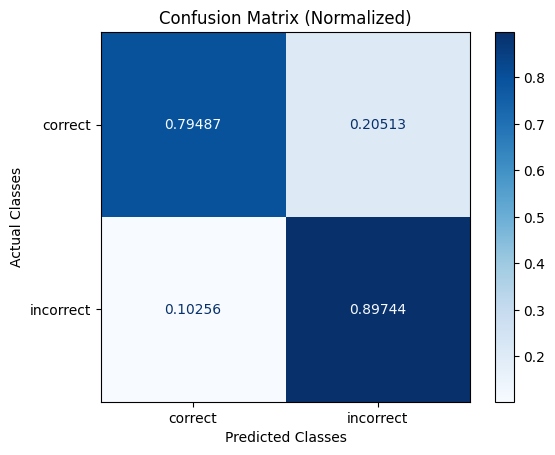

In [12]:
true_labels = df["true_value"].map(HUMAN_VS_AI_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications['label'], labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=list(true_labels), predict_vector=list(relevance_classifications['label']), classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## LLM Evals: Human Groundtruth vs AI  Classifications GPT-3.5 Turbo
Run against a subset of the data using GPT-3.5. GPT-3.5 can significantly speed up the classification process. However there are tradeoffs as  we will see below.

In [13]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [14]:
rails = list(HUMAN_VS_AI_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=HUMAN_VS_AI_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=50
)["label"].tolist()

llm_classify |██████████| 119/119 (100.0%) | ⏳ 00:23<00:00 |  5.12it/s


              precision    recall  f1-score   support

     correct       0.72      0.94      0.82        78
   incorrect       0.72      0.33      0.46        39

   micro avg       0.72      0.74      0.73       117
   macro avg       0.72      0.63      0.64       117
weighted avg       0.72      0.74      0.70       117



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

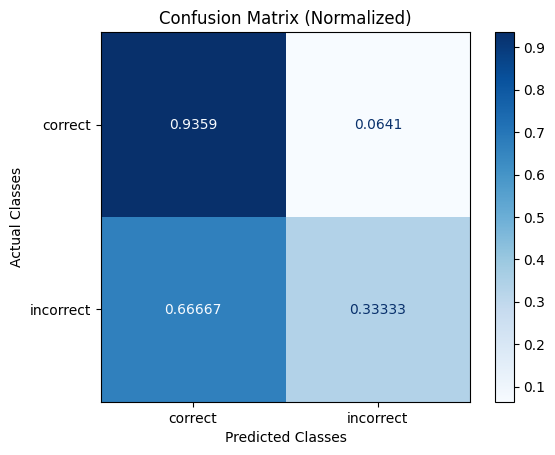

In [15]:
true_labels = df["true_value"].map(HUMAN_VS_AI_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Preview: Running with GPT-4 Turbo

In [16]:
model = OpenAIModel(model_name="gpt-4-1106-preview")
relevance_classifications = llm_classify(
    dataframe=df,
    template=HUMAN_VS_AI_PROMPT_TEMPLATE,
    model=model,
    rails=list(HUMAN_VS_AI_PROMPT_RAILS_MAP.values()),
    concurrency=50
)["label"].tolist()

llm_classify |██████████| 119/119 (100.0%) | ⏳ 00:23<00:00 |  5.10it/s


              precision    recall  f1-score   support

     correct       0.87      0.69      0.77        78
   incorrect       0.56      0.82      0.67        39

   micro avg       0.72      0.74      0.73       117
   macro avg       0.72      0.76      0.72       117
weighted avg       0.77      0.74      0.74       117



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

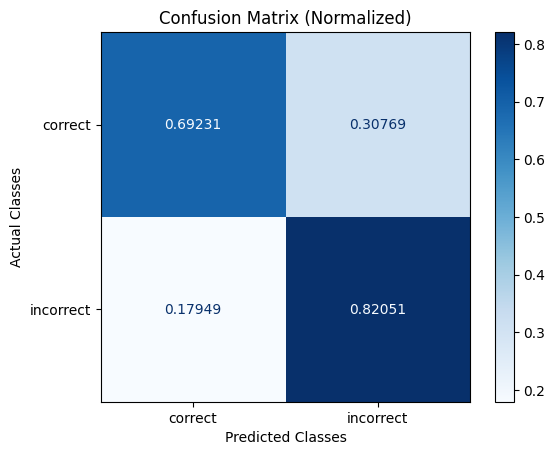

In [17]:
true_labels = df["true_value"].map(HUMAN_VS_AI_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)